In [30]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
from newspaper import Article
import spacy
#nlp = spacy.load('en_core_web_lg')
import en_core_web_lg
nlp = en_core_web_lg.load()
#wikipedia dict


In [31]:
article = pd.read_csv('sample_data.csv')
article.columns = ['idx','tags','text','genre','cluster']
article = article.head(100)
article = article.dropna()
article.head(5)

,idx,tags,text,genre,cluster
0,19,d77e674abd042be04a8e644d023764d9,A man jumped to his death from a high-rise con...,Kill by physical assault,3.0
1,44,243b0d67a8bd945bd994b0d6607c2729,"A former Minister of Aviation, Chief Osita Chi...","Threaten, not specified below",3.0
2,45,2de077cba1272d4581f86a1a1cda4d10,North Korean leader Kim Jong Un said the world...,"Threaten, not specified below",3.0
3,95,8e9e70ecd9192803779bca2f85a1ea02,Photo by RobShotsNiagara Falls police and the ...,"Threaten, not specified below",3.0
4,106,c8011ead21923ba8c5b836a9ae1916c5,"DECATUR, Ala – It’s a part of everyday life th...","Threaten, not specified below",3.0


In [32]:
#import three lists: titles, links and wikipedia synopses
titles = article.tags.tolist()

synopses = article.text.tolist()
    
genres = article.genre.tolist()
# print (genres)
print(str(len(titles)) + ' titles')
print(str(len(synopses)) + ' synopses')
print(str(len(genres)) + ' genres')
# synopses[0]

90 titles
90 synopses
90 genres


In [33]:
print ("titles: ", titles[0])
text = synopses[0]

titles:  d77e674abd042be04a8e644d023764d9


In [34]:
def get_relations(id, text):
    print ("Working for title: ", id)
    text = re.sub(r'\n+', '.', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = nlp(text)
#     text = nlp(text._.coref_resolved)  # resolve coreference clusters
    sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    ent_pairs = list()
    who = set()
    where = set()
    when = set()
#     sent = sentences[0]
    for sent in sentences:
        sent = nlp(sent)
        #print (sent)
        spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        spans = spacy.util.filter_spans(spans)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span) for span in spans]
        for ent in sent.ents:
            if ent.label_ == "GPE" and ent.text not in where:
                where.add(ent.text)
                ent_pairs.append({ "title": id, "relation": "occurs at", "object": ent.text })
            elif ent.label_ == "PERSON" and ent.text not in who:
                who.add(ent.text)
                ent_pairs.append({ "title": id, "relation": "is about", "object": ent.text })
            elif ent.label_ == "TIME" and ent.text not in when:
                when.add(ent.text)
                ent_pairs.append({ "title": id, "relation": "at time", "object": ent.text })
            else:
                #print ("No match", ent.label_, "==>", ent.text)
                next

        
    pairs = pd.DataFrame(ent_pairs, columns=['title',
                     'relation', 'object'])

    print('Entity pairs extracted:', str(len(ent_pairs)))
    return pairs
#         print ("it happened at: ", where)
#         print ("around: ", when)
#         print ("with: ", who)
#         print ("relation", relation)



In [35]:
import networkx as nx
import matplotlib.pyplot as plt


def draw_kg(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'title', 'object',
            create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(120, 90), dpi=80)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
        )
    labels = dict(zip(list(zip(pairs.title, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')

    plt.show()

In [36]:
all_pairs = pd.DataFrame([], columns=['title',
                     'relation', 'object'])
# for index, title in enumerate(titles):
for index in range(0,10):
    pairs = get_relations(titles[index],synopses[index])
    all_pairs = all_pairs.append(pairs, ignore_index = True)
print (all_pairs)

Working for title:  d77e674abd042be04a8e644d023764d9
Entity pairs extracted: 8
Working for title:  243b0d67a8bd945bd994b0d6607c2729
Entity pairs extracted: 6
Working for title:  2de077cba1272d4581f86a1a1cda4d10
Entity pairs extracted: 19
Working for title:  8e9e70ecd9192803779bca2f85a1ea02
Entity pairs extracted: 1
Working for title:  c8011ead21923ba8c5b836a9ae1916c5
Entity pairs extracted: 7
Working for title:  1b6b616b632ed12327d1423251de39d9
Entity pairs extracted: 3
Working for title:  43aeb068b4414c8499eb6f22a22a435e
Entity pairs extracted: 4
Working for title:  b700c620a582c38764601747d8b140a2
Entity pairs extracted: 24
Working for title:  ae5cb9e0b9129c57fb307cccdbe04c41
Entity pairs extracted: 25
Working for title:  bda6f231e5ccf15d0b3898fe3b3534cc
Entity pairs extracted: 11
                                title   relation  \
0    d77e674abd042be04a8e644d023764d9  occurs at   
1    d77e674abd042be04a8e644d023764d9    at time   
2    d77e674abd042be04a8e644d023764d9    at time  

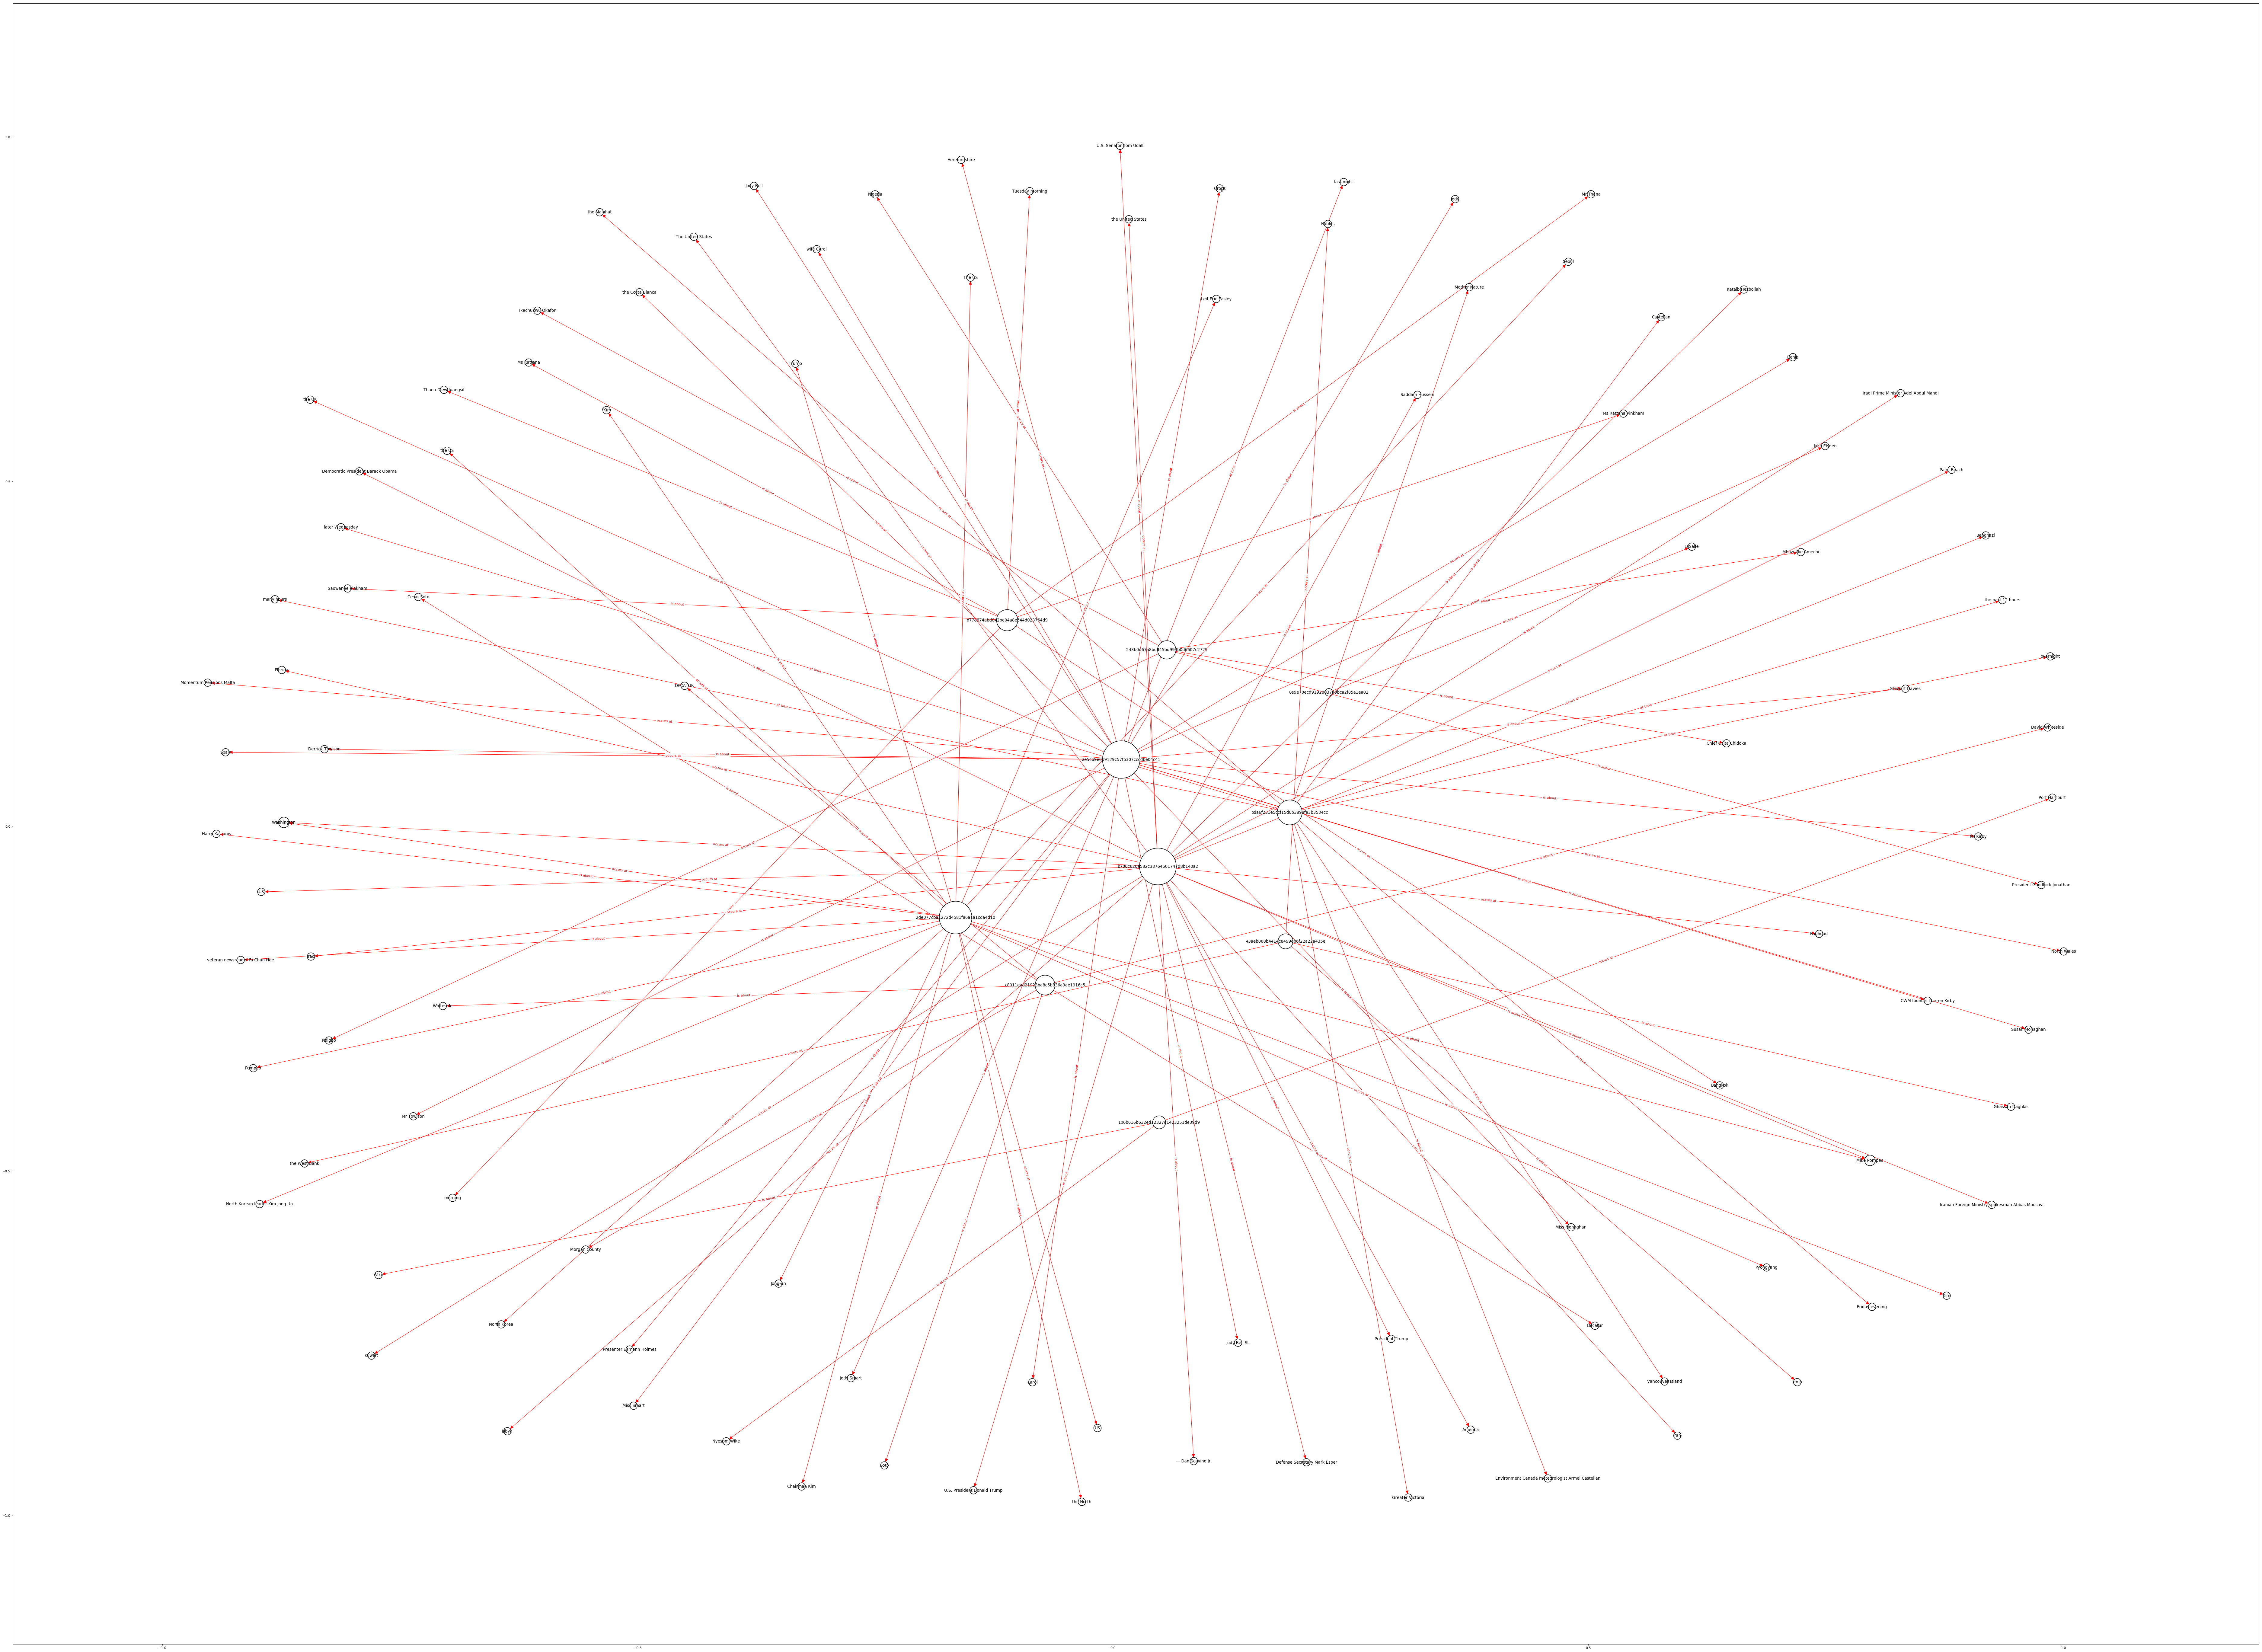

In [37]:
draw_kg(all_pairs)
